**Author:** *Johannes Peter Knoll*

# Introduction

This Notebook is supposed to demonstrate that the functions implemented in this project work correctly.
If you trust my coding skills you can skip this, as it is unnecessarily thorough and was mainly designed 
to help me check my functions.

In [1]:
# The autoreload extension allows you to tweak the code in the imported modules
# and rerun cells to reflect the changes.
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Parameters and Files

In [92]:
# IMPORTS
import random
import numpy as np
import wfdb.processing

In [3]:
# LOCAL IMPORTS
import main
import read_edf
import MAD
import rpeak_detection
import check_data
import plot_helper
import rri_from_rpeak
from side_functions import *

In [4]:
parameters = main.parameters

# Signals in EDF-Files

The .edf file holds many signals / channels, which can be accessed using the following function. 
We will load the ECG Channel for example (and visualize it).

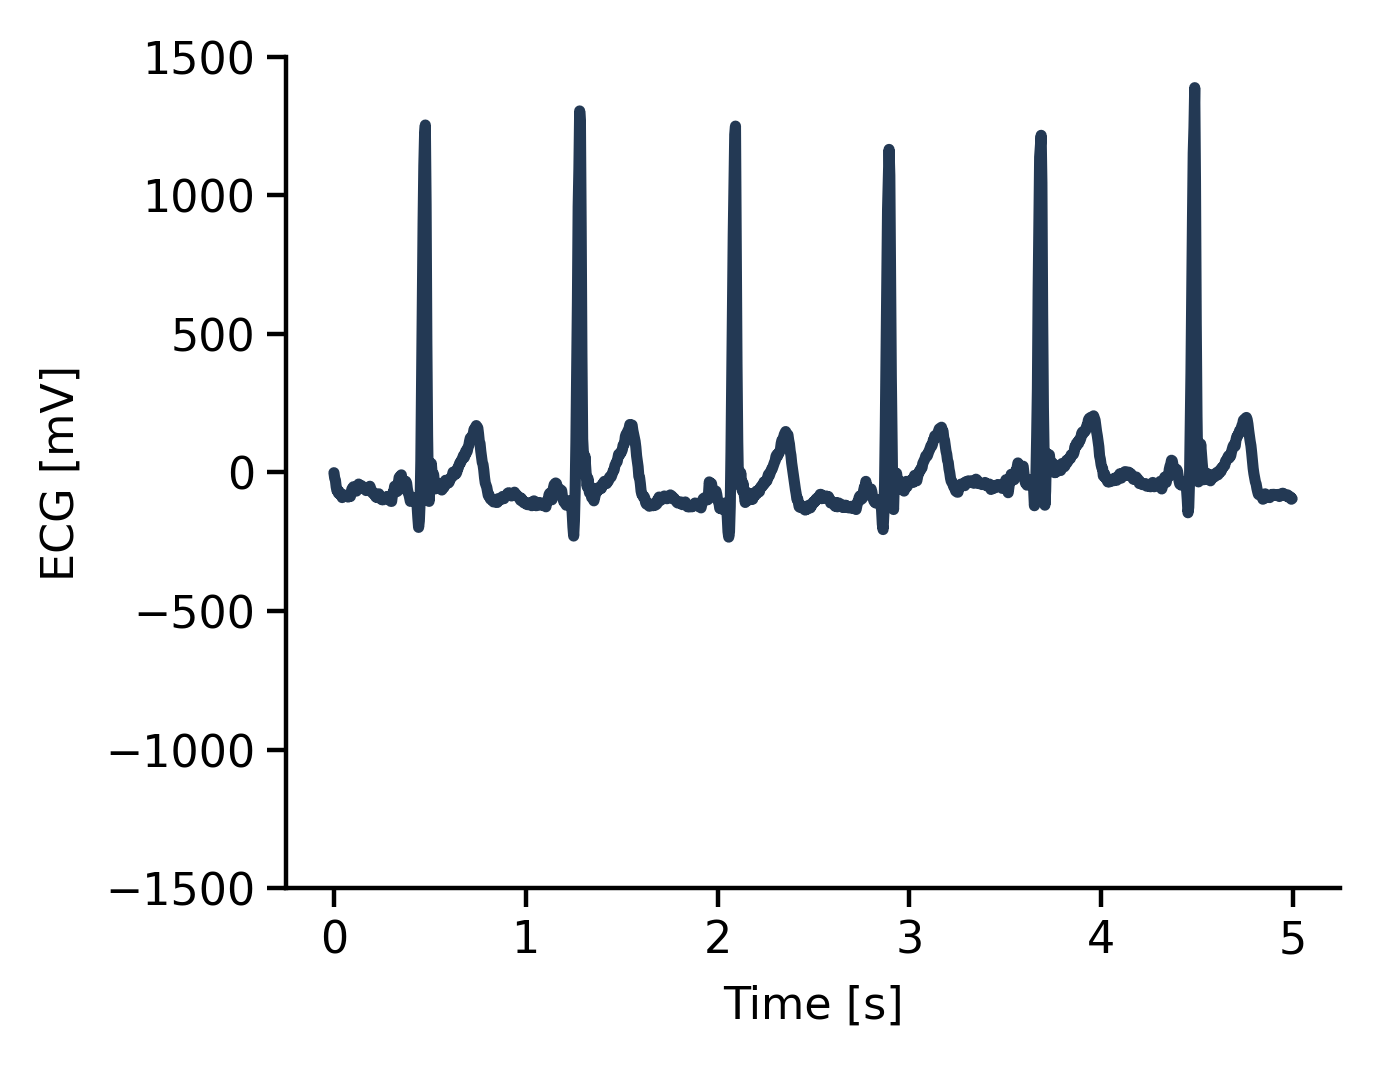

In [95]:
# choose a random edf file
file_data_name = "Somnowatch_Messung.edf"
file_data_path = "Data/" + file_data_name

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = file_data_path,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

interval_size = 1280 # 5 seconds for 256 Hz

lower_border = 2091000 # normal
# lower_border = 6292992 + 640 # normal with fluktuations
# lower_border = 1781760 # normal but negative peaks
# lower_border = 2156544 # normal but noisier

# lower_border = 17752064 # hard noise
# lower_border = 18344704 # not as extreme overkill
# lower_border = 10788096 + 640 # continous flat, one large spike 
# lower_border = 19059968 # extreme overkill

xlim = [lower_border, lower_border + interval_size]

data_y = ECG[lower_border:lower_border + interval_size]

# plot ECG
plt = plot_helper.simple_plot(
    data_x = np.array([i for i in range(len(data_y))]) / frequency, 
    data_y = data_y, 
    xlabel = "Time [s]",
    ylabel = "ECG [mV]",
    ylim = [-1500, 1500]
    )

plt.show()

# ECG Validation

## Straighten the ECG signal:

To improve the recognition of valid ECG regions (during ECG Validation) the signal will be "straightened" first.

The Straightening is demonstrated below:

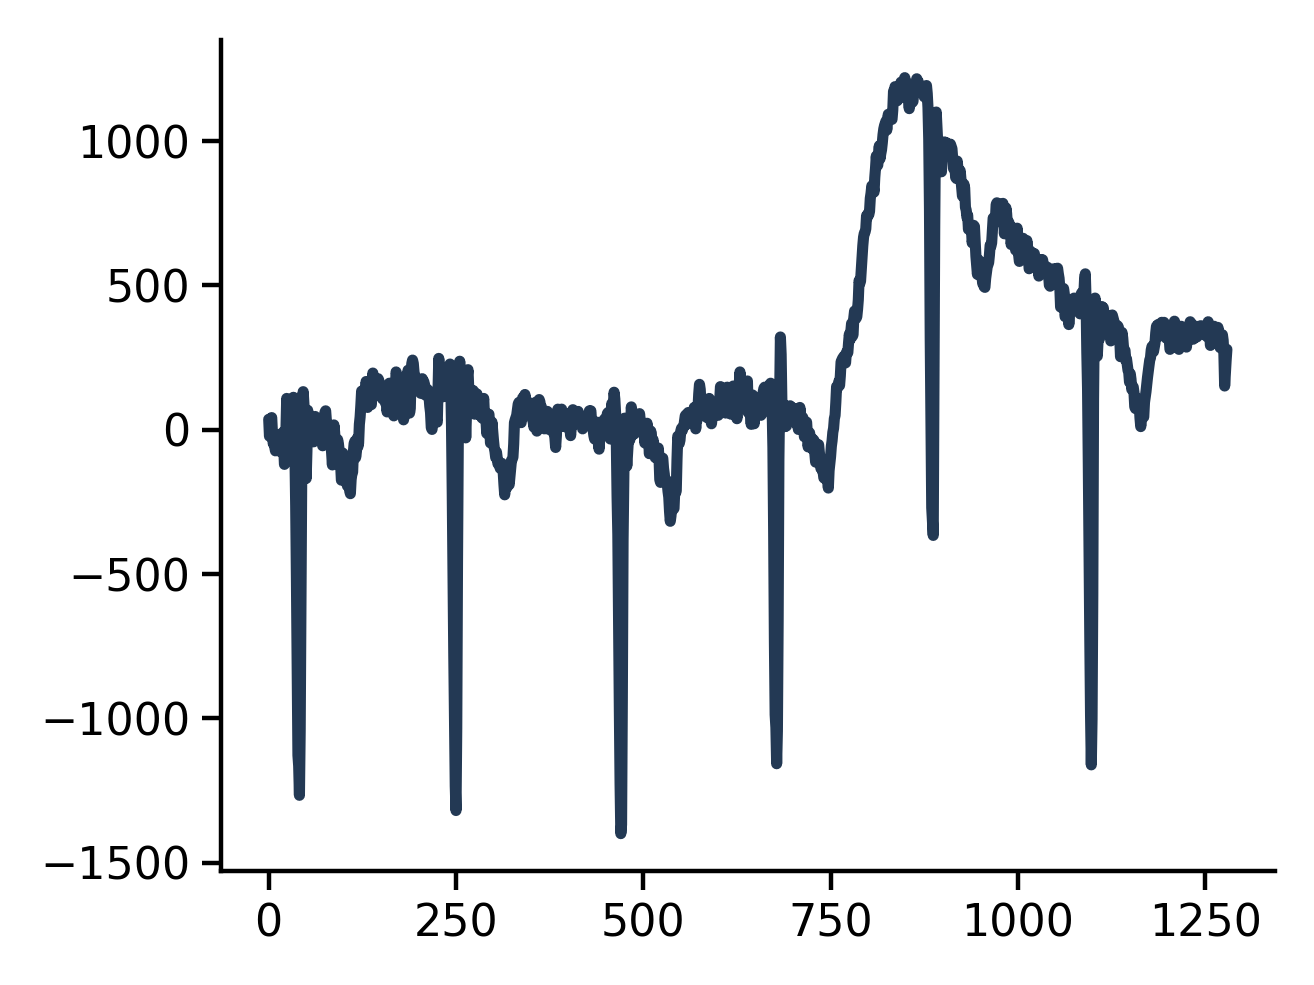

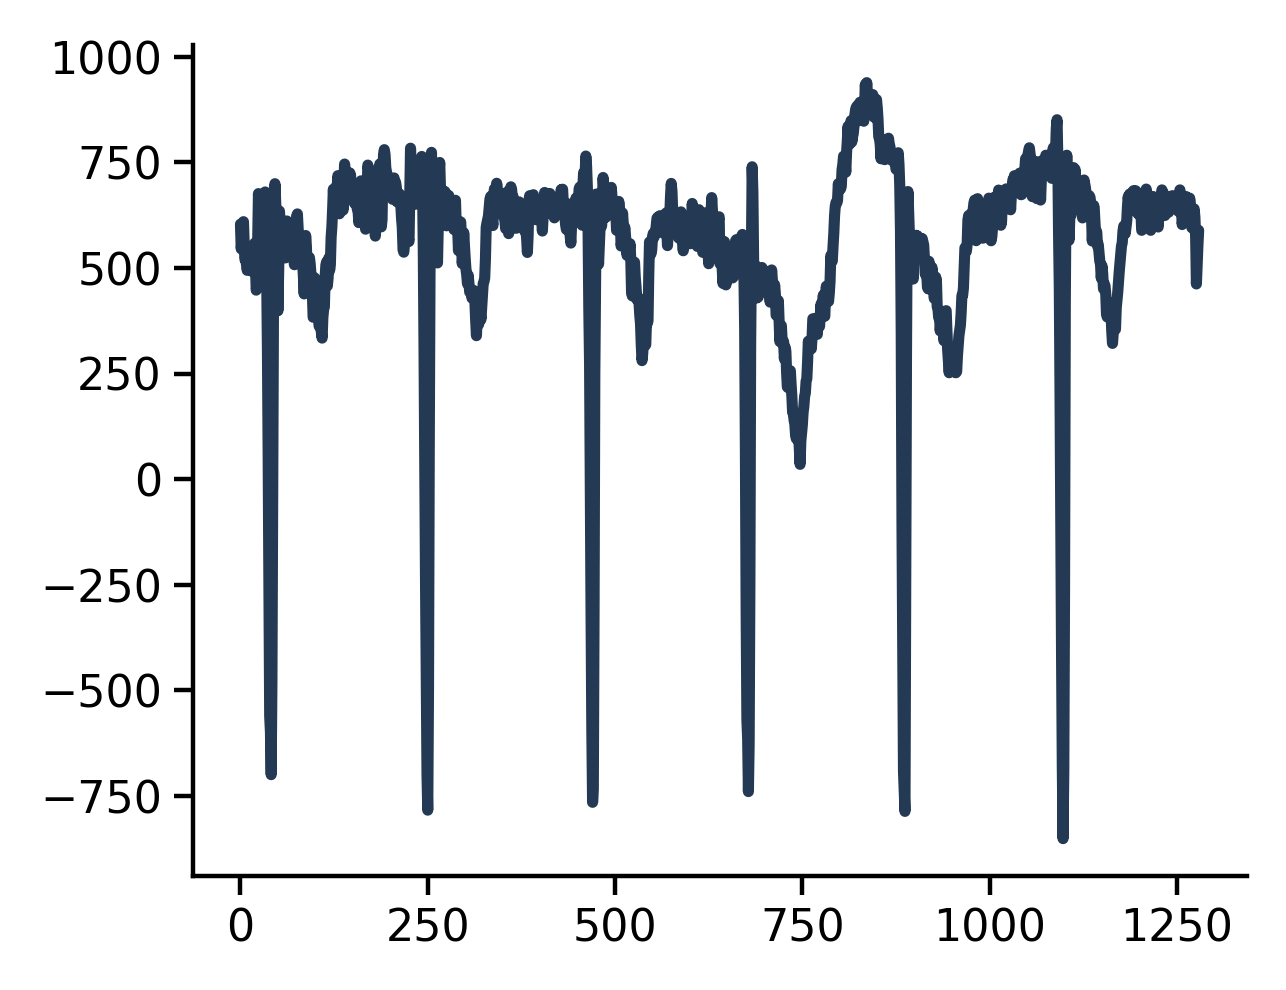

In [97]:
# choose a random file
data_directory = "Data/"
file_data_name = "Somnowatch_Messung.edf"
file_data_path = data_directory + file_data_name

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = file_data_path,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

lower_border = 1012500
interval_size = 1280
interval = [lower_border, lower_border + interval_size]
ecg_signal = ECG[lower_border:lower_border + interval_size]

plt = plot_helper.simple_plot(data_x = [i for i in range(len(ecg_signal))], data_y = ecg_signal)
plt.show()

straightened_ecg = check_data.straighten_ecg(ecg_signal, frequency)

plt = plot_helper.simple_plot(data_x = [i for i in range(len(straightened_ecg))], data_y = straightened_ecg)
plt.show()

## Evaluate and show valid ECG regions:

Demonstration of ECG Validation:

(Valid / Total) Regions Ratio: 78.120000 %


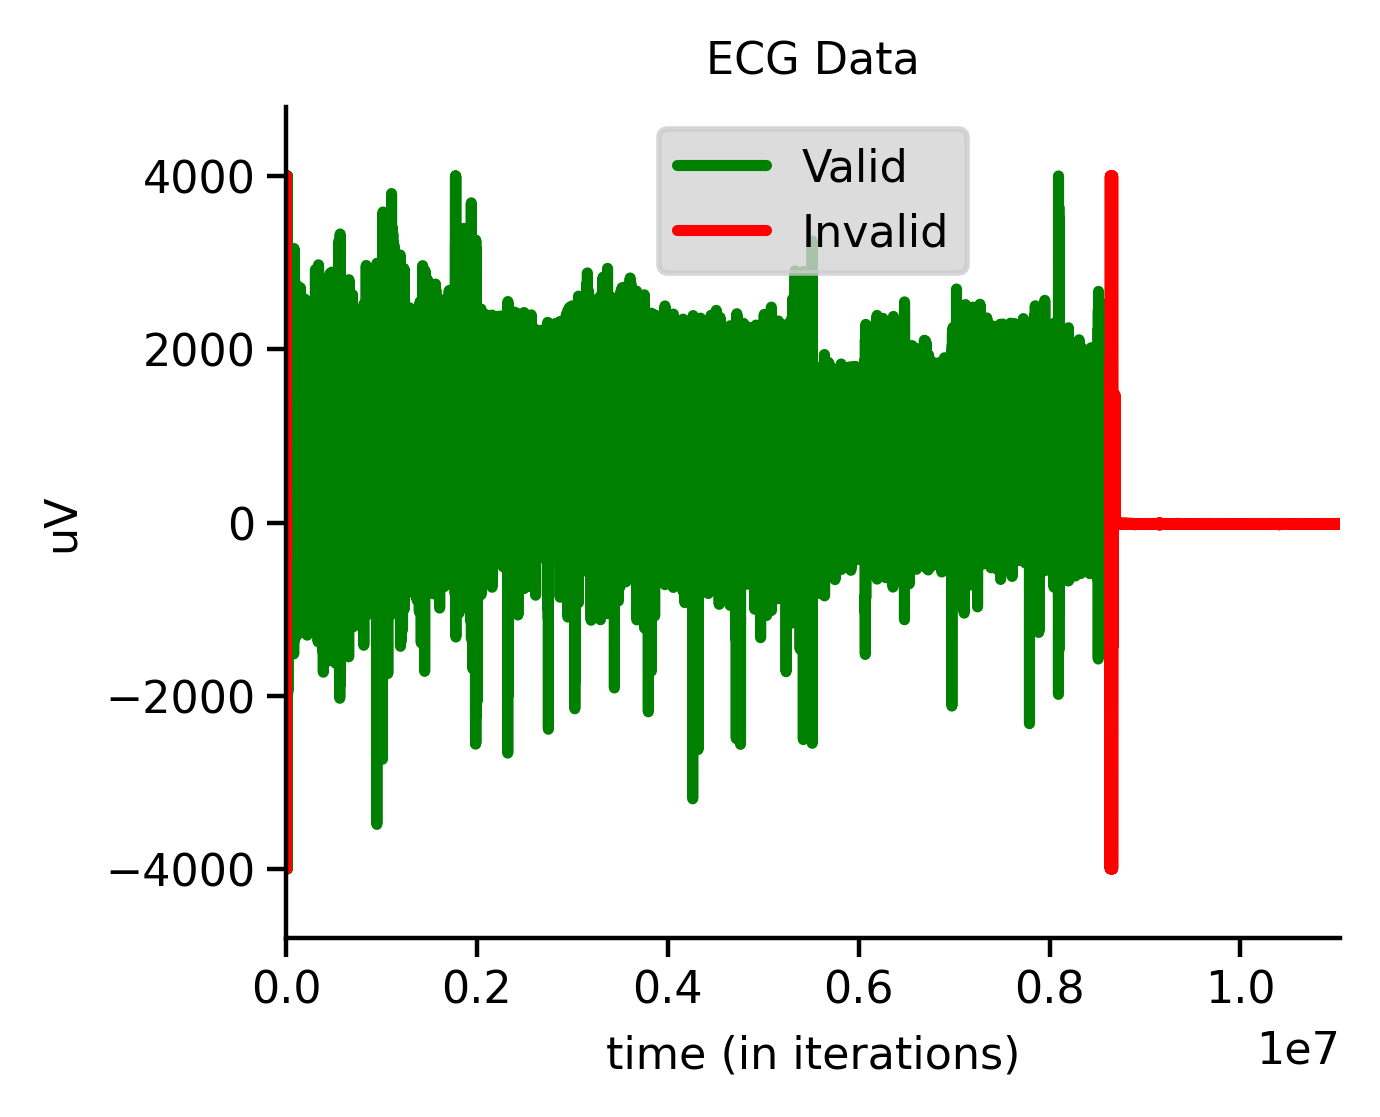

In [6]:
# choose a random file
data_directory = "Data/GIF/SOMNOwatch/"
file_data_name = "SL104_SL104_(1).edf"
file_data_path = data_directory + file_data_name

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = file_data_path,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

# calculate valid ECG regions for different validation strictness
results = check_data.check_ecg(
    ECG=ECG, 
    frequency=frequency, 
    check_ecg_time_interval_seconds=5,  
    straighten_ecg_signal=True, 
    check_ecg_overlapping_interval_steps=1, 
    check_ecg_validation_strictness=[0.4, 0.6, 0.8],
    check_ecg_removed_peak_difference_threshold=0.3,
    check_ecg_std_min_threshold=80,
    check_ecg_std_max_threshold=800,
    check_ecg_distance_std_ratio_threshold=5,
    check_ecg_allowed_invalid_region_length_seconds=30,
    check_ecg_min_valid_length_minutes=5,
    )

valid_regions_for_one_val_strictness = results[1] # access the valid regions for the second validation strictness

# calculate the ratio of valid regions to total regions
valid_regions_ratio = check_data.determine_valid_total_ecg_ratio(
    ECG_length = len(ECG), 
    valid_regions = valid_regions_for_one_val_strictness
    )
print("(Valid / Total) Regions Ratio: %f %%" % (round(valid_regions_ratio, 4)*100))

# choose region to plot
total_length = len(ECG)
x_lim = [int(0*total_length), int(1*total_length)]

plot_helper.plot_valid_regions(
    ECG = ECG, 
    valid_regions = valid_regions_for_one_val_strictness,
    xlim = x_lim
    )

# Calculating R-Peaks

Demonstration of R-Peak Detection:

ATTENTION: You must choose a valid interval yourself!

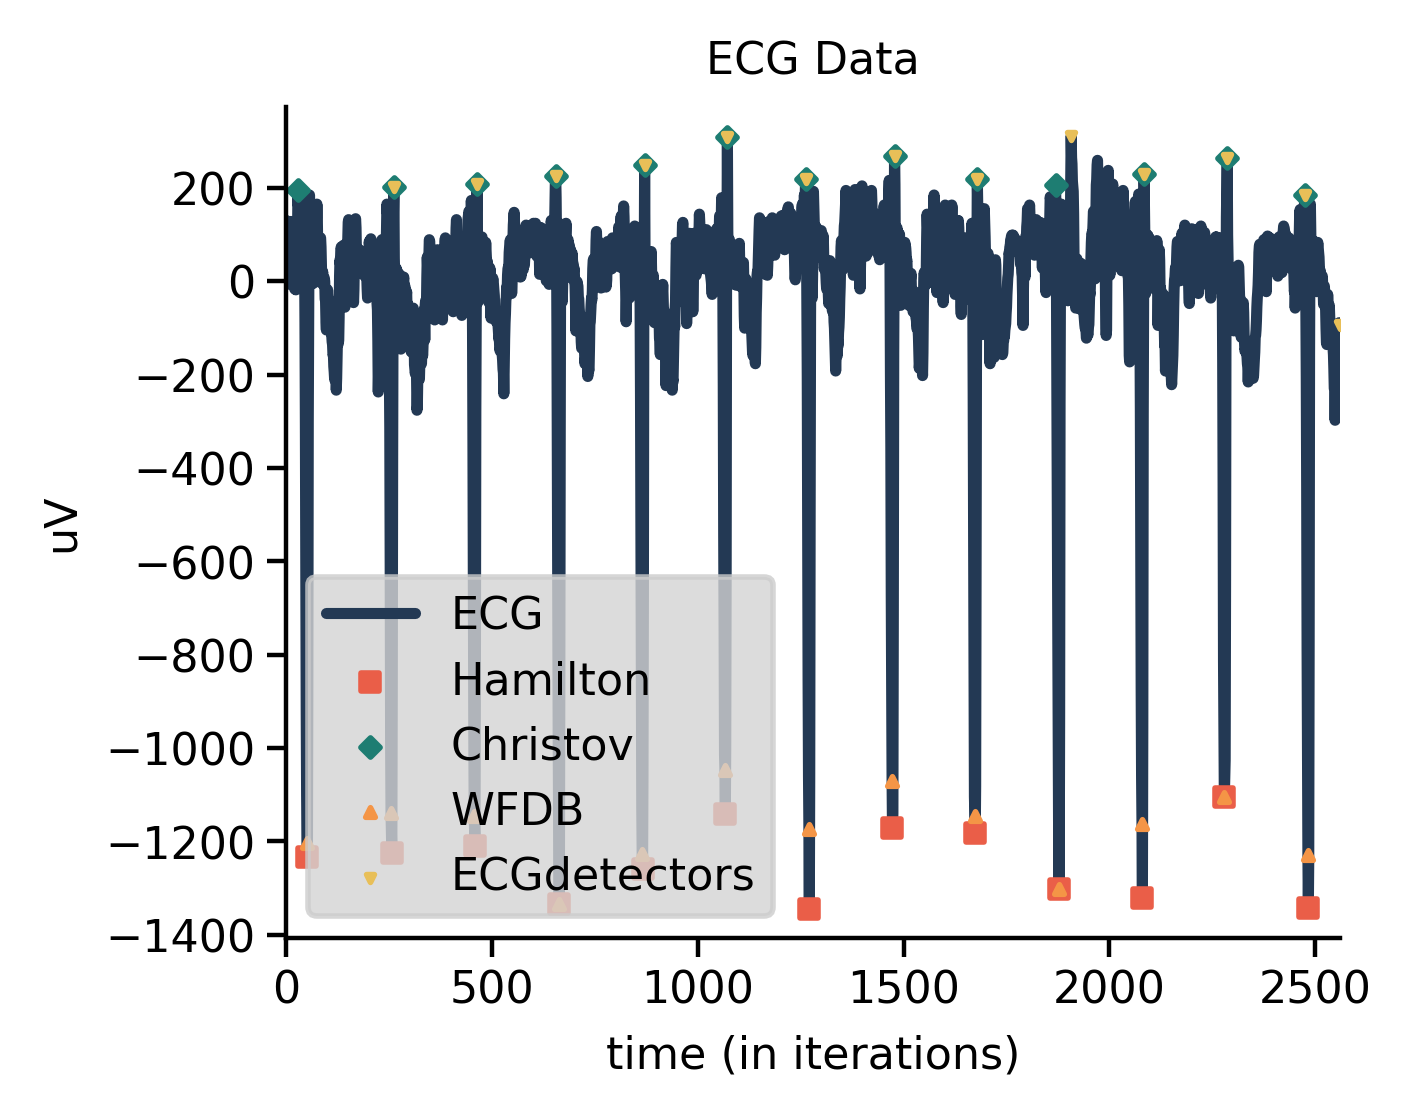

In [93]:
# choose a random file
data_directory = "Data/"
file_data_name = "Somnowatch_Messung.edf"

# choose interval
interval_size = 2560
lower_bound = 1781760
interval = [lower_bound, lower_bound + interval_size]

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = data_directory + file_data_name,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

ecg_signal = ECG[interval[0]:interval[1]]

# calculate r-peaks
rpeaks_hamilton = rpeak_detection.get_rpeaks_hamilton(ecg_signal, frequency, None) # type: ignore
rpeaks_christov = rpeak_detection.get_rpeaks_christov(ecg_signal, frequency, None) # type: ignore
rpeaks_wfdb = rpeak_detection.get_rpeaks_wfdb(ecg_signal, frequency, None) # type: ignore
rpeaks_ecgdet = rpeak_detection.get_rpeaks_ecgdetectors(ecg_signal, frequency, None) # type: ignore

# plot the r-peaks
plot_helper.plot_rpeak_detection(
    ECG = ecg_signal,
    rpeaks = [rpeaks_hamilton,rpeaks_christov,rpeaks_wfdb,rpeaks_ecgdet],
    rpeaks_name = ["Hamilton","Christov","WFDB", "ECGdetectors"],
)

## Correcting R-Peak Locations

Detected R-Peak locations are corrected using the function below:

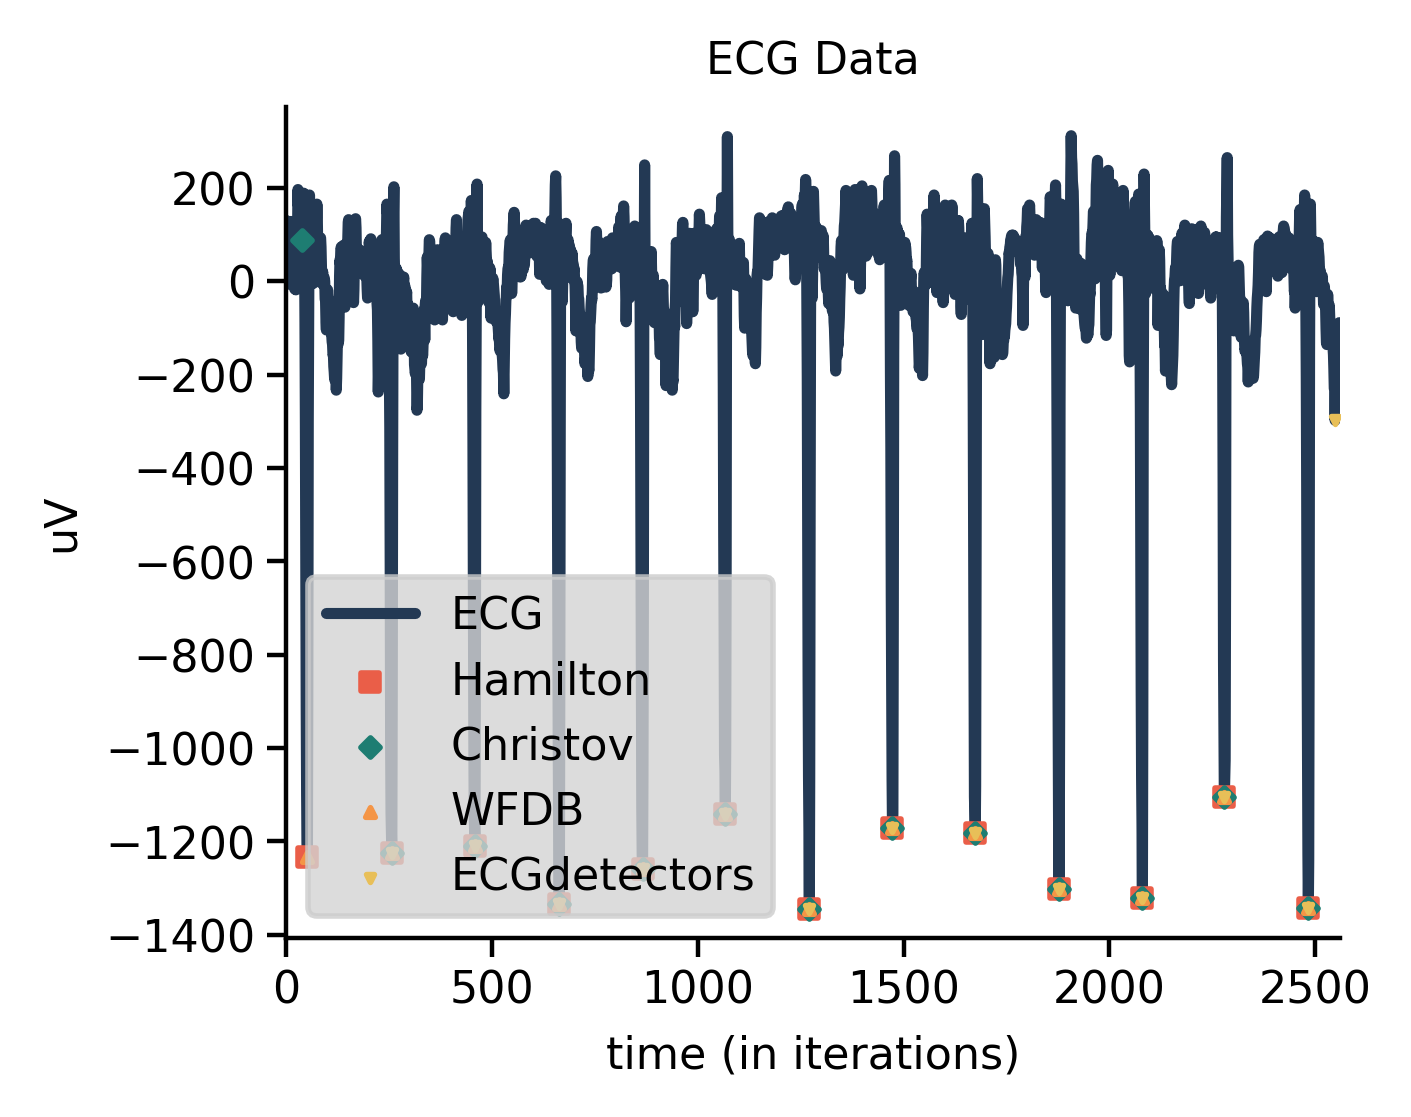

In [94]:
# calculate r-peaks
rpeaks_hamilton = wfdb.processing.correct_peaks(ecg_signal, rpeaks_hamilton, search_radius=36, smooth_window_size=50)
rpeaks_christov = wfdb.processing.correct_peaks(ecg_signal, rpeaks_christov, search_radius=36, smooth_window_size=50)
rpeaks_wfdb = wfdb.processing.correct_peaks(ecg_signal, rpeaks_wfdb, search_radius=36, smooth_window_size=50)
rpeaks_ecgdet = wfdb.processing.correct_peaks(ecg_signal, rpeaks_ecgdet, search_radius=36, smooth_window_size=50)

# plot the r-peaks
plot_helper.plot_rpeak_detection(
    ECG = ecg_signal,
    rpeaks = [rpeaks_hamilton,rpeaks_christov,rpeaks_wfdb,rpeaks_ecgdet],
    rpeaks_name = ["Hamilton","Christov","WFDB", "ECGdetectors"],
)

# Calculating RRI Values

In [103]:
some_rpeak_locations = [i * 256 + random.randint(-10, 10) for i in range(10)] # heart rate of 60 bpm for sampling frequency of 256 Hz
if some_rpeak_locations[0] < 0:
    some_rpeak_locations[0] = 0
    
print("Some rpeak locations: ", some_rpeak_locations)
rri = rri_from_rpeak.calculate_rri_from_peaks(
    rpeaks = some_rpeak_locations, 
    ecg_sampling_frequency = 256, 
    target_sampling_frequency = 4, 
    signal_length = some_rpeak_locations[-1]
)
print("RRI: ", rri)

rri = rri_from_rpeak.calculate_rri_from_peaks(
    rpeaks = some_rpeak_locations, 
    ecg_sampling_frequency = 256, 
    target_sampling_frequency = 0.2, 
    signal_length = some_rpeak_locations[-1]
)
print("RRI: ", rri)

Some rpeak locations:  [1, 250, 519, 775, 1020, 1278, 1539, 1793, 2055, 2306]
RRI:  [0, 0.97265625, 0.97265625, 0.97265625, 1.05078125, 1.05078125, 1.05078125, 1.05078125, 1.05078125, 1.0, 1.0, 1.0, 1.0, 0.95703125, 0.95703125, 0.95703125, 1.0078125, 1.0078125, 1.0078125, 1.0078125, 1.01953125, 1.01953125, 1.01953125, 1.01953125, 1.01953125, 0.9921875, 0.9921875, 0.9921875, 0.9921875, 1.0234375, 1.0234375, 1.0234375, 1.0234375, 0.98046875, 0.98046875, 0.98046875]
RRI:  [0.99765625]


In [8]:
some_rpeak_locations = [719978, 720177, 720405, 720616, 720859, 721111, 721331, 721571, 721792, 722018, 722246, 722479, 722698, 722918, 723163, 723395, 723629, 723857, 724085, 724302]
some_rpeak_locations = np.array(some_rpeak_locations)
some_rpeak_locations = some_rpeak_locations - some_rpeak_locations[0]
print(some_rpeak_locations)
print("\n")
print(rri_from_rpeak.calculate_rri_from_peaks(
    rpeaks = some_rpeak_locations, 
    ecg_sampling_frequency = 256, 
    target_sampling_frequency = 0.2, 
    signal_length = 5000))


some_rpeak_locations = [723629, 723857, 724085, 724302, 724302+1000*256, 724302+1000*256+0.7*256, 724302+1000*256+1.4*256]
some_rpeak_locations = np.array(some_rpeak_locations)
some_rpeak_locations = some_rpeak_locations - some_rpeak_locations[0]
print(some_rpeak_locations)
print("\n")
print(rri_from_rpeak.calculate_rri_from_peaks(
    rpeaks = some_rpeak_locations, 
    ecg_sampling_frequency = 256, 
    target_sampling_frequency = 4, 
    signal_length = 50000*6))

[   0  199  427  638  881 1133 1353 1593 1814 2040 2268 2501 2720 2940
 3185 3417 3651 3879 4107 4324]


[0.88515625, 0.896875, 0.9091796875]
[0.000000e+00 2.280000e+02 4.560000e+02 6.730000e+02 2.566730e+05
 2.568522e+05 2.570314e+05]


[0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.890625, 0.84765625, 0.84765625, 0.84765625, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.

# Calculating MAD Values

The calculated MAD Values will be plotted in a random interval. Of course you can change the
interval size or even define the interval yourself. Go ahead and look at a few different intervals
for different files!

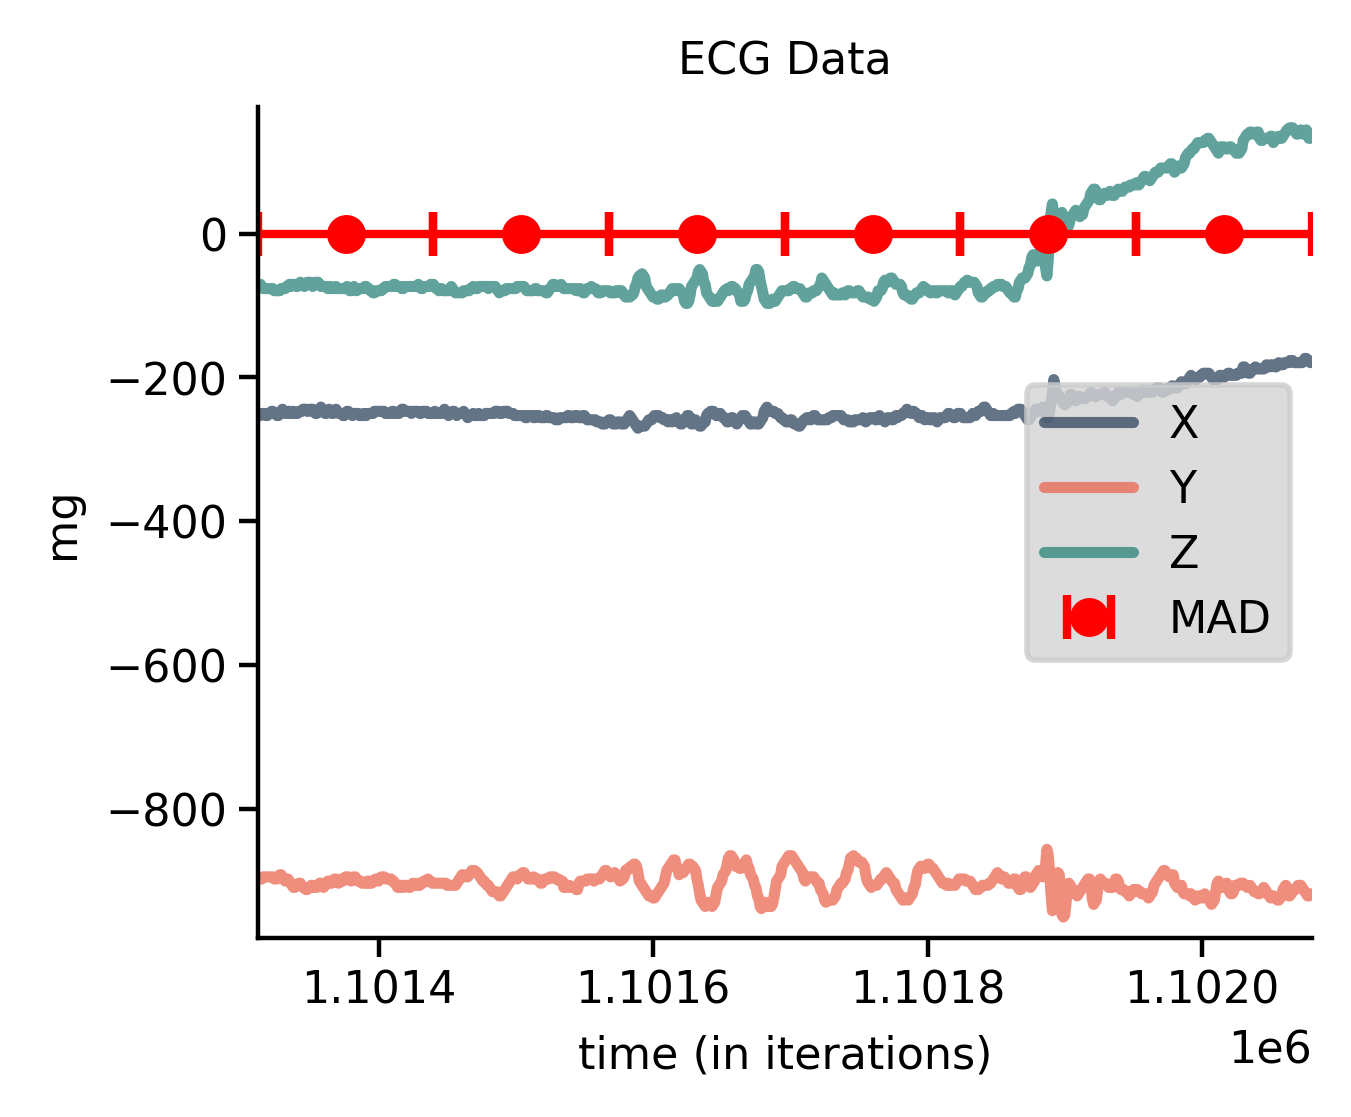

In [9]:
# choose a random file
data_directory = "Data/"
file_data_name = "Somnowatch_Messung.edf"

file_data_path = data_directory + file_data_name

# choose size of interval
interval_size = 768 # 6 seconds for 128 Hz

# create lists to save the acceleration data and frequencies for each axis
acceleration_data = []
acceleration_data_frequencies = []

# get the acceleration data and frequency for each axis
for possible_axis_keys in parameters["wrist_acceleration_keys"]:
    this_axis_signal, this_axis_frequency = read_edf.get_data_from_edf_channel(
        file_path = file_data_path,
        possible_channel_labels = possible_axis_keys,
        physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

    # append data to corresponding lists
    acceleration_data.append(this_axis_signal)
    acceleration_data_frequencies.append(this_axis_frequency)

# load data and choose random valid interval
total_length = len(acceleration_data[0])
frequency = acceleration_data_frequencies[0]

# calculate MAD values
this_files_MAD_values = MAD.calc_mad(
        acceleration_data_lists = acceleration_data,
        frequencies = acceleration_data_frequencies, 
        time_period = 1,
    )

# choose random region to plot
random_valid_region_start = random.randint(0, total_length - interval_size)
random_valid_region_start = 1101312
x_lim = [random_valid_region_start, random_valid_region_start + interval_size]

plot_helper.plot_MAD_values(
    acceleration_data = acceleration_data,
    frequency = frequency,
    MAD_values = this_files_MAD_values, # type: ignore
    mad_time_period_seconds = parameters["mad_time_period_seconds"], 
    xlim = x_lim
    )